In [ ]:
#!pip install dask[complete]

In [ ]:
import dask.dataframe as dd
import numpy 
import pandas as pd
import os
from commun import fonctions as fct
from commun import fonction_plot as fp 
from commun import Opset as Op
from IPython.display import display


import matplotlib.pyplot as plt

In [ ]:
def extract_h5(repertoire_source):
    extract={}
    
    for nom_fichier in os.listdir(repertoire_source):
        if nom_fichier[-3:]=='.h5':
            ddf=fct.lire_hdf_dask(nom_fichier, repertoire_source)
            extract[nom_fichier]=ddf
            print(f"DataFrame Dask du fichier {nom_fichier} a été chargé")
    return extract

chemin_repertoire="D:"

# La variable extract est un dictionnaire dans lequel chaque paire clé-valeur correspond à un Dask DataFrame associé à un avion

extract=extract_h5(chemin_repertoire)
            


Ce HDFStore n'est pas partitionnable et ne peut être utilisé de manière monolithique qu'avec pandas.
Création d'un nouveau fichier de données: 'Aircraft_01_dask.h5'
Lecture du fichier de données: 'Aircraft_01_dask.h5'
DataFrame Dask du fichier Aircraft_01.h5 a été chargé
Ce HDFStore n'est pas partitionnable et ne peut être utilisé de manière monolithique qu'avec pandas.
Création d'un nouveau fichier de données: 'Aircraft_02_dask.h5'
Lecture du fichier de données: 'Aircraft_02_dask.h5'
DataFrame Dask du fichier Aircraft_02.h5 a été chargé
Ce HDFStore n'est pas partitionnable et ne peut être utilisé de manière monolithique qu'avec pandas.
Création d'un nouveau fichier de données: 'Aircraft_03_dask.h5'
Lecture du fichier de données: 'Aircraft_03_dask.h5'
DataFrame Dask du fichier Aircraft_03.h5 a été chargé


# Affichage interactif des caractéristiques de chaque vol pour les 3 avions

In [ ]:
# Récupération des clés du dictionnaire 
keys=list(extract.keys())

List_chemins=[]
for key in keys:
    #Affichage du nombre de partitions de chaque avion
    print(f"L'avion {key} contient {extract[key].npartitions} partitions.")
 

    #Affichage interactif
for key in keys:
    ds1=(Op.Opset(chemin_repertoire + "/" + key)).plot()
    display(ds1)




L'avion Aircraft_01.h5 contient 1001 partitions.
L'avion Aircraft_02.h5 contient 1002 partitions.
L'avion Aircraft_03.h5 contient 1002 partitions.


In [ ]:
import matplotlib.pyplot as plt 

def tracer_serie_temporelle(ddf, numero_partition, colonnes):
    """
    Trace la série temporelle pour les colonnes spécifiées à partir d'une table donnée dans le fichier HDF5.
    
    Paramètres:
    - ddf : dask dataframe
    - numero_partition: Le numéro de la table à charger à partir du fichier HDF5.
    - colonnes: Une liste de colonnes à tracer.
    """
    donnees = ddf.partitions[numero_partition].compute()
    
    # Tracer la série temporelle pour les colonnes spécifiées
    for col in colonnes:
        plt.figure(figsize=(12, 6))
        plt.plot(donnees[col], label=col, alpha=0.7)
        plt.title(f'Série temporelle de {col} - Vol: {numero_partition}')
        plt.xlabel('Temps')
        plt.ylabel(col)
        plt.grid(True)
        plt.legend()
        plt.show()

tracer_serie_temporelle(extract[keys[0]], 0, ['ALT [ft]', 'EGT_1 [deg C]', 'FMV_1 [mm]', 'HPTACC_1 [%]', 'M [Mach]'])




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


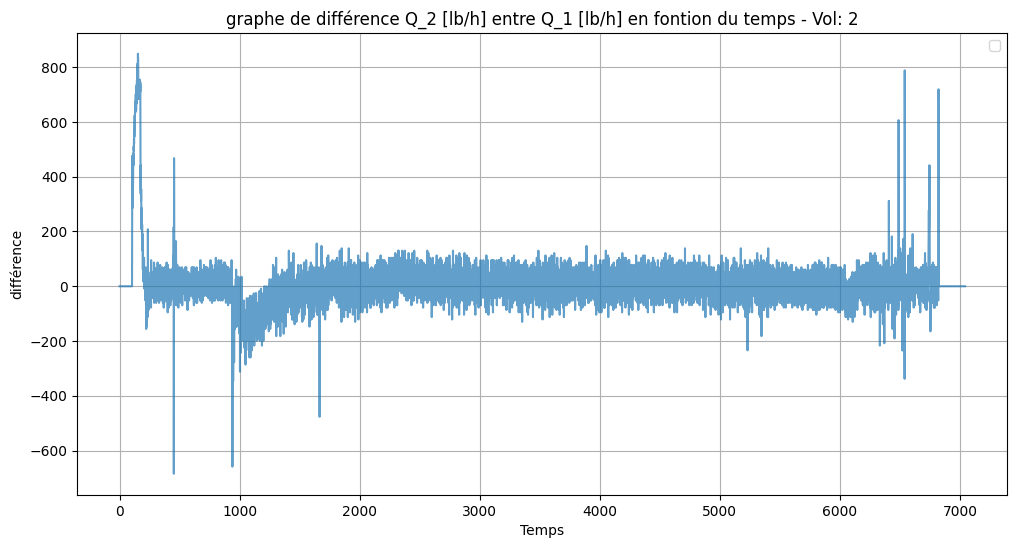

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


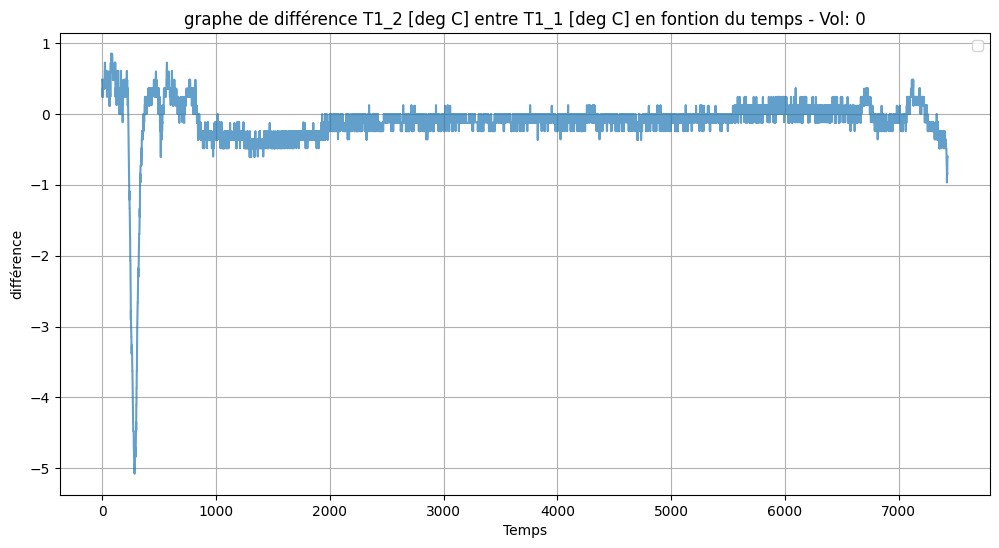

In [ ]:
def graphe_comparaison_différence(ddf, numero_partition, abs, ord):
    """
    Trace la série temporelle pour les colonnes spécifiées à partir d'une table donnée dans le fichier HDF5.
    
    Paramètres:
    - ddf : dask dataframe
    - numero_partition: Le numéro de la table à charger à partir du fichier HDF5.
    - colonnes: Une liste de colonnes à tracer.
    """
    donnees = ddf.partitions[numero_partition].compute()
    
    # Tracer la série temporelle pour les colonnes spécifiées
    plt.figure(figsize=(12, 6))
    plt.plot(donnees[abs]-donnees[ord], alpha=0.7)
    plt.title(f'graphe de différence {abs} entre {ord} en fontion du temps - Vol: {numero_partition}')
    plt.xlabel('Temps')
    plt.ylabel('différence')
    plt.grid(True)
    plt.legend()
    plt.show()
graphe_comparaison_différence(extract[keys[0]], 2, 'Q_2 [lb/h]', 'Q_1 [lb/h]')
graphe_comparaison_différence(extract[keys[0]], 0, 'T1_2 [deg C]', 'T1_1 [deg C]')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


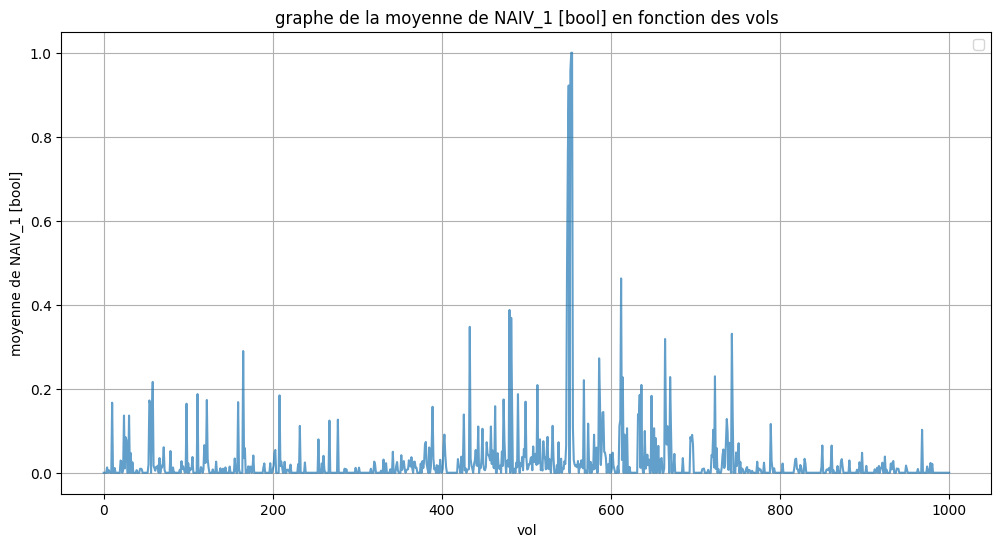

In [ ]:
def moyenne_sur_colonne(ddf, col):
    """
    Trace la série temporelle pour les colonnes spécifiées à partir d'une table donnée dans le fichier HDF5.
    
    Paramètres:
    - ddf : dask dataframe
    - numero_partition: Le numéro de la table à charger à partir du fichier HDF5.
    - colonnes: Une liste de colonnes à tracer.
    """
    moyenne=[]
    """
    for numero_partition in range(ddf.npartitions):

        donnees = ddf.partitions[numero_partition].compute()
        moyenne.append(numpy.mean(donnees[col]))
    """
    moyenne=(ddf.map_partitions(lambda df: df[col].mean()).compute())
    
    # Tracer la série temporelle pour les colonnes spécifiées
    plt.figure(figsize=(12, 6))
    plt.plot(moyenne, alpha=0.7)
    plt.title(f'graphe de la moyenne de {col} en fonction des vols')
    plt.xlabel('vol')
    plt.ylabel(f'moyenne de {col}')
    plt.grid(True)
    plt.legend()
    plt.show()
#moyenne_sur_colonne(extract[keys[0]], 'Q_1 [lb/h]')
moyenne_sur_colonne(extract[keys[0]], 'NAIV_1 [bool]')


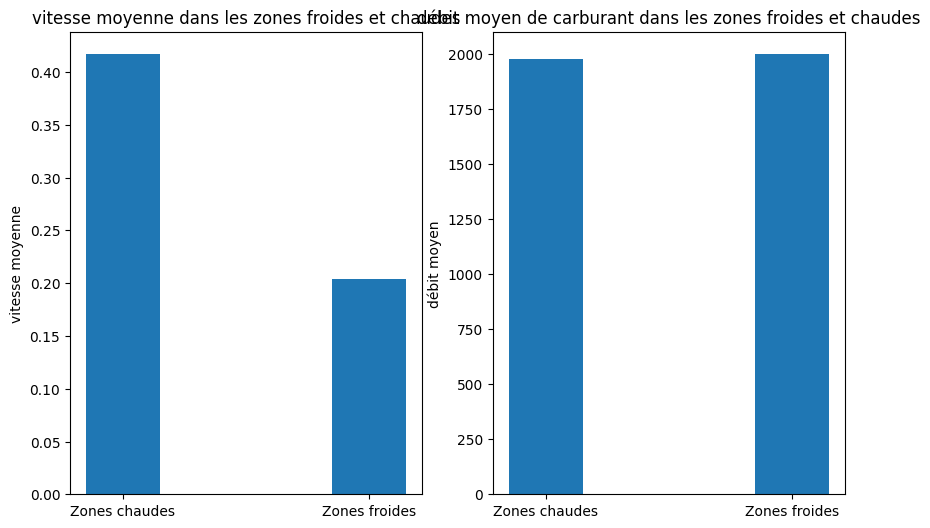

In [ ]:
vitesse_zones = extract[keys[0]].groupby('NAIV_1 [bool]').agg({'M [Mach]': 'mean'}).compute()


plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.bar(numpy.arange(vitesse_zones.size), vitesse_zones['M [Mach]'], tick_label=['Zones chaudes', 'Zones froides'], width=0.3)
plt.title(f'vitesse moyenne dans les zones froides et chaudes')
plt.ylabel('vitesse moyenne')

debit_zones = extract[keys[0]].groupby('NAIV_1 [bool]').agg({'Q_1 [lb/h]': 'mean'}).compute()

plt.subplot(1,2,2)
plt.bar(numpy.arange(debit_zones.size), debit_zones['Q_1 [lb/h]'], tick_label=['Zones chaudes', 'Zones froides'], width=0.3)
plt.title(f'débit moyen de carburant dans les zones froides et chaudes')
plt.ylabel('débit moyen')
plt.show()

In [ ]:
grouped_data.index

Index([0.0, 1.0], dtype='float64', name='NAIV_1 [bool]')